# Running Simulations

## Introduction

The purpose of this notebook is to demonstrate how to run CT simulations using open-source head phantoms as a part of **Aim 1.3**.

![](../project_aims.png)
*This notebook focuses on Aim 1.3, CT Dataset Generation Pipeline*

Previously for the [pilot study](https://github.com/bnel1201/Virtual-Patient-CT-Simulations/blob/PedSilicoICH-Pilot/pedsilico-pilot.ipynb) we demonstrated inserting simple circular lesions into an XCAT head phantom using the [XCIST simulation framework](https://github.com/xcist).

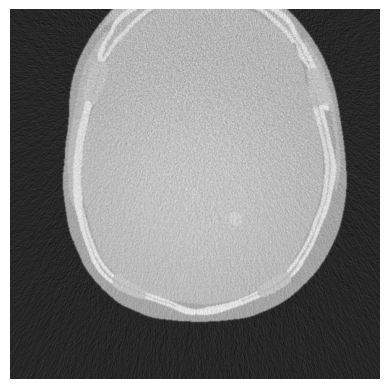

In [1]:
from dxcist.xcist_sims import run_simulation, get_projection_data, get_reconstructed_data

In [2]:
run_simulation?

Signature:
run_simulation(
    ground_truth_image,
    output_dir,
    phantom_id='default',
    slice_id=0,
    mA=200,
    kVp=120,
    FOV=None,
    mu_water=None,
)
Docstring: <no docstring>
File:      ~/Dev/Virtual-Patient-CT-Simulations/src/dxcist/xcist_sims.py
Type:      function

In [3]:
import nibabel as nib
from pathlib import Path
phantom_dir = Path('../MIDA Head Phantom')
img = nib.load(phantom_dir/'MIDA_v1.nii')

In [4]:
import matplotlib.pyplot as plt
import numpy as np

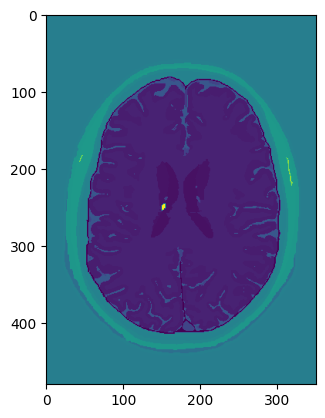

In [5]:
phantom = np.array(img.get_fdata()).transpose(1, 0, 2)
plt.imshow(phantom[320])

Below is the look up table for each segment, next step is assigning each an appropriate linear attenuation coefficient then running through `run_simulation`

In [6]:
from io import StringIO
import pandas as pd
with open(phantom_dir / 'MIDA_v1.txt', 'rb') as data:
    df = pd.read_csv(StringIO(data.read().decode(errors='replace')), sep='\t', names=['c1', 'c2', 'c3', 'material'], index_col=0)
    temp = df.iloc[-8:, 0].T
    nx, ny, nz, dx, dy, dz = temp.nx, temp.ny, temp.nz, temp.dx, temp.dy, temp.dz
    material_lut = df.iloc[:-8]
material_lut

,c1,c2,c3,material
1,0.000000,0.988235,1.000000,Dura
2,1.000000,0.780392,0.000000,Cerebellum Gray Matter
3,0.658824,1.000000,1.000000,Pineal Body
4,0.000000,0.000000,1.000000,Amygdala
5,1.000000,0.423529,1.000000,Hippocampus
...,...,...,...,...
112,0.000000,1.000000,0.000000,Cranial Nerve IX - Glossopharyngeal
113,0.650980,0.376471,0.596078,Cranial Nerve X - Vagus
114,0.082353,0.458824,0.207843,Cranial Nerve XI - Accessory
115,1.000000,1.000000,0.000000,Cranial Nerve XII - Hypoglossal


I'm not sure how these 3 color channels correspond to the gray scale image (if it were a 3 channel image it would make sense). But it is not clear how to convert these 3 channel labels to gray scale in a unique way. I'll start with reading the gray scale values directly off of ImageJ and will contact the dataset authors if I need further help MIDAmodel@fda.hhs.gov,  virtualpopulation@itis.swiss

My goal is to reproduce the steps done here: [open source XCIST demo](https://github.com/bnel1201/XCIST_demo/blob/main/opensource_peds_demo.ipynb) of assigning each labeled anatomy to an xcist material for converting to linear attenuation units

See also Wiki LUT for CT numbers: https://en.wikipedia.org/wiki/Hounsfield_scale

In [7]:
material_lut.material.unique()

array(['Dura', 'Cerebellum Gray Matter', 'Pineal Body', 'Amygdala',
       'Hippocampus', 'CSF Ventricles', 'Caudate Nucleus', 'Putamen',
       'Cerebellum White Matter', 'Brain Gray Matter',
       'Brainstem Midbrain', 'Brain White Matter', 'Spinal Cord',
       'Brainstem Pons', 'Brainstem Medulla', 'Nucleus Accumbens',
       'Globus Pallidus', 'Optic Tract', 'Hypophysis or Pituitary Gland',
       'Mammillary Body', 'Hypothalamus', 'Commissura (Anterior)',
       'Commissura (Posterior)', 'Blood Arteries', 'Blood Veins',
       'Air Internal - Ethmoidal Sinus', 'Air Internal - Frontal Sinus',
       'Air Internal - Maxillary Sinus',
       'Air Internal - Sphenoidal Sinus', 'Air Internal - Mastoid',
       'Air Internal - Nasal/Pharynx', 'CSF General', 'Ear Cochlea',
       'Ear Semicircular Canals', 'Ear Auricular Cartilage (Pinna)',
       'Mandible', 'Mucosa', 'Muscle (General)',
       'Nasal Septum (Cartilage)', 'Skull', 'Teeth', 'Tongue',
       'Adipose Tissue', 'Vertebra 

https://github.com/xcist/main/tree/master/gecatsim/material

In [8]:
from utils import ctshow

In [9]:
material_lut.loc[material_lut.material=='Cerebellum Gray Matter', 'grayscale'] = 10
material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'xcist material'] = 'gray_matter'
material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'CT Number [HU]'] = 45

material_lut.loc[material_lut.material=='Brain Gray Matter', 'grayscale'] = 10
material_lut.loc[material_lut.material=='Brain Gray Matter', 'xcist material'] = 'gray_matter'
material_lut.loc[material_lut.material=='Brain Gray Matter', 'CT Number [HU]'] = 45

material_lut.loc[material_lut.material=='Thalamus', 'grayscale'] = 116
material_lut.loc[material_lut.material=='Thalamus', 'xcist material'] = 'gray_matter'
material_lut.loc[material_lut.material=='Thalamus', 'CT Number [HU]'] = 45

material_lut.loc[material_lut.material=='Cerebellum White Matter', 'grayscale'] = 12
material_lut.loc[material_lut.material=='Cerebellum White Matter', 'xcist material'] = 'white_matter'
material_lut.loc[material_lut.material=='Cerebellum White Matter', 'CT Number [HU]'] = 20

material_lut.loc[material_lut.material=='Brain White Matter', 'grayscale'] = 12
material_lut.loc[material_lut.material=='Brain White Matter', 'xcist material'] = 'white_matter'
material_lut.loc[material_lut.material=='Brain White Matter', 'CT Number [HU]'] = 20


material_lut.loc[material_lut.material=='CSF General', 'grayscale'] = 32
material_lut.loc[material_lut.material=='CSF General', 'xcist material'] = 'CSF'
material_lut.loc[material_lut.material=='CSF General', 'grayscale'] = 32
material_lut.loc[material_lut.material=='CSF General', 'CT Number [HU]'] = 15
material_lut.loc[material_lut.material=='CSF Ventricles', 'xcist material'] = 'CSF'
material_lut.loc[material_lut.material=='CSF Ventricles', 'CT Number [HU]'] = 15

material_lut.loc[material_lut.material=='Skull', 'grayscale'] = 62
material_lut.loc[material_lut.material=='Skull', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull', 'CT Number [HU]'] = 900

material_lut.loc[material_lut.material=='Skull Diplo�', 'grayscale'] = 52
material_lut.loc[material_lut.material=='Skull Diplo�', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull Diplo�', 'CT Number [HU]'] = 800 # https://en.wikipedia.org/wiki/Diplo%C3%AB

material_lut.loc[material_lut.material=='Skull Inner Table', 'grayscale'] = 52
material_lut.loc[material_lut.material=='Skull Inner Table', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull Inner Table', 'CT Number [HU]'] = 1000

material_lut.loc[material_lut.material=='Skull Outer Table', 'grayscale'] = 54
material_lut.loc[material_lut.material=='Skull Outer Table', 'xcist material'] = 'ncat_skull'
material_lut.loc[material_lut.material=='Skull Outer Table', 'CT Number [HU]'] = 1000

material_lut.loc[material_lut.material=='Adipose Tissue', 'grayscale'] = 62
material_lut.loc[material_lut.material=='Adipose Tissue', 'CT Number [HU]'] = -120

material_lut.loc[material_lut.material=='Muscle (General)', 'grayscale'] = 63
material_lut.loc[material_lut.material=='Muscle (General)', 'CT Number [HU]'] = 55

material_lut[~material_lut['CT Number [HU]'].isna()]

/tmp/ipykernel_158399/2949165353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_lut.loc[material_lut.material=='Cerebellum Gray Matter', 'grayscale'] = 10
/tmp/ipykernel_158399/2949165353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  material_lut.loc[material_lut.material=='Cerebellum  Gray Matter', 'xcist material'] = 'gray_matter'
/tmp/ipykernel_158399/2949165353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,c1,c2,c3,material,grayscale,xcist material,CT Number [HU]
6,0.368627,0.588235,0.549020,CSF Ventricles,NaN,CSF,15.0
9,0.713726,0.121569,0.341176,Cerebellum White Matter,12.0,white_matter,20.0
10,0.521569,0.521569,0.533333,Brain Gray Matter,10.0,gray_matter,45.0
12,1.000000,1.000000,1.000000,Brain White Matter,12.0,white_matter,20.0
32,0.411765,0.000000,0.000000,CSF General,32.0,CSF,15.0
38,0.450980,0.776471,0.125490,Muscle (General),63.0,NaN,55.0
40,1.000000,1.000000,0.588235,Skull,62.0,ncat_skull,900.0
43,0.690196,0.478431,1.000000,Adipose Tissue,62.0,NaN,-120.0
52,0.745098,0.000000,0.000000,Skull Diplo�,52.0,ncat_skull,800.0
53,0.309804,0.000000,0.294118,Skull Inner Table,52.0,ncat_skull,1000.0


In [10]:
material_lut.loc[material_lut.material=='Muscle (General)']

,c1,c2,c3,material,grayscale,xcist material,CT Number [HU]
38,0.45098,0.776471,0.12549,Muscle (General),63.0,NaN,55.0


In [11]:
np.unique(phantom[300])

array([  1.,   6.,   7.,   8.,  10.,  12.,  17.,  24.,  25.,  27.,  32.,
        37.,  43.,  50.,  51.,  52.,  53.,  54.,  61.,  62.,  63.,  64.,
        98., 116.])

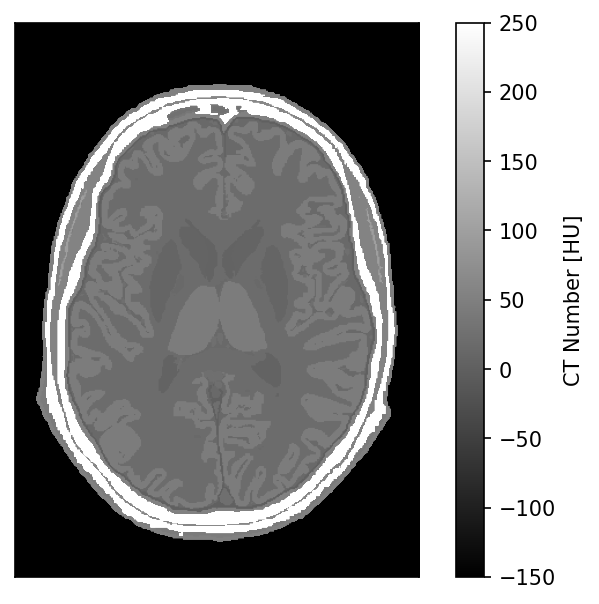

In [12]:
phantom[phantom == 50] = -1000 # air
for idx, row in material_lut[~material_lut['CT Number [HU]'].isna()].iterrows():
    phantom[phantom==row.grayscale] = row['CT Number [HU]']
plt.figure(dpi=150)
ctshow(phantom[300])
plt.colorbar(label='CT Number [HU]')

In [13]:
from ipywidgets import interact, IntSlider

interact(lambda idx: ctshow(phantom[idx]), idx=IntSlider(value=phantom.shape[0]//2, min=0, max=phantom.shape[0]))

interactive(children=(IntSlider(value=240, description='idx', max=480), Output()), _dom_classes=('widget-inter…

<function __main__.<lambda>(idx)>

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 1 slices...
* Writing volume fraction files for 5 materials and 1 slices, plus the HU data...
* 

  0%|                                                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of      3 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:59<00:00,  3.34it/s]


Prep view
Applying LSC...done.

Simulation is done.
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


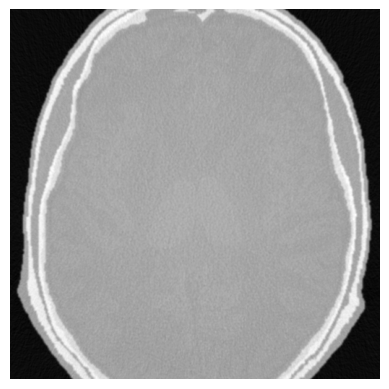

In [14]:
ct = run_simulation(ground_truth_image=phantom[300], output_dir='test')

Example of [normal brain CT](https://nbia.cancerimagingarchive.net/viewer/?study=1.3.6.1.4.1.14519.5.2.1.3098.5025.922017993220231365363448902707&series=1.3.6.1.4.1.14519.5.2.1.3098.5025.127673560102649811051571885155&token=eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJkZGFhMGY3YS1kZTBmLTRkYWQtYjM1ZS05MjljYjBiMTY3YjgifQ.eyJleHAiOjE3MDQ0MDA4NDYsImlhdCI6MTcwNDM5MzY0NiwianRpIjoiZDU4YTI0M2YtNGQwZi00MjljLTg0NDQtMGI5MjJjNzUzNWQ0IiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5kYm1pLmNsb3VkL2F1dGgvcmVhbG1zL1RDSUEiLCJhdWQiOiJhY2NvdW50Iiwic3ViIjoiZjowMTliNTYzNC1kYWJkLTQyMTEtYTQxZC03MjNjNDRhZmNmZmQ6bmJpYV9ndWVzdCIsInR5cCI6IkJlYXJlciIsImF6cCI6Im5iaWEiLCJzZXNzaW9uX3N0YXRlIjoiYzc5OTIxMTItZjcyYS00OWY5LWI0ZTMtOWY3ZTFmN2I0NzQ5IiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL3NlcnZpY2VzLmNhbmNlcmltYWdpbmdlYXJjaGl2ZS5uZXQiLCJodHRwczovL25iaWEuY2FuY2VyaW1hZ2luZ2VhcmNoaXZlLm5ldCIsImh0dHBzOi8vd3d3LmNhbmNlcmltYWdpbmdlYXJjaGl2ZS5uZXQiLCIqIiwiaHR0cDovL3RjaWEtbmJpYS0yLmFkLnVhbXMuZWR1OjQ1MjEwIiwiaHR0cHM6Ly9jYW5jZXJpbWFnaW5nZWFyY2hpdmUubmV0IiwiaHR0cDovL3RjaWEtbmJpYS0xLmFkLnVhbXMuZWR1OjQ1MjEwIiwiaHR0cHM6Ly9wdWJsaWMuY2FuY2VyaW1hZ2luZ2VhcmNoaXZlLm5ldCJdLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJkZWZhdWx0LXJvbGVzLXRjaWEiLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZW1haWwiLCJzaWQiOiJjNzk5MjExMi1mNzJhLTQ5ZjktYjRlMy05ZjdlMWY3YjQ3NDkiLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmFtZSI6Ik5CSUEgR3Vlc3QiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJuYmlhX2d1ZXN0IiwiZ2l2ZW5fbmFtZSI6Ik5CSUEiLCJmYW1pbHlfbmFtZSI6Ikd1ZXN0IiwiZW1haWwiOiJuYmlhX2d1ZXN0QGNhbmNlcmltYWdpbmdhcmNoaXZlLm5ldCJ9.q7c8o4AZK8cnCMYmZD_TjGvGyLIAZBysMJNIVV3agrE) for reference

In [15]:
recon = get_reconstructed_data(ct).squeeze()

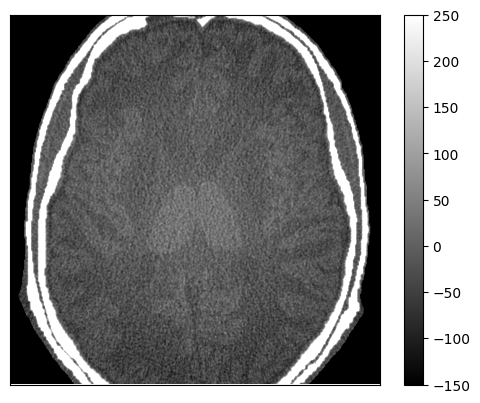

In [16]:
ctshow(recon, 'soft tissues')
plt.colorbar()

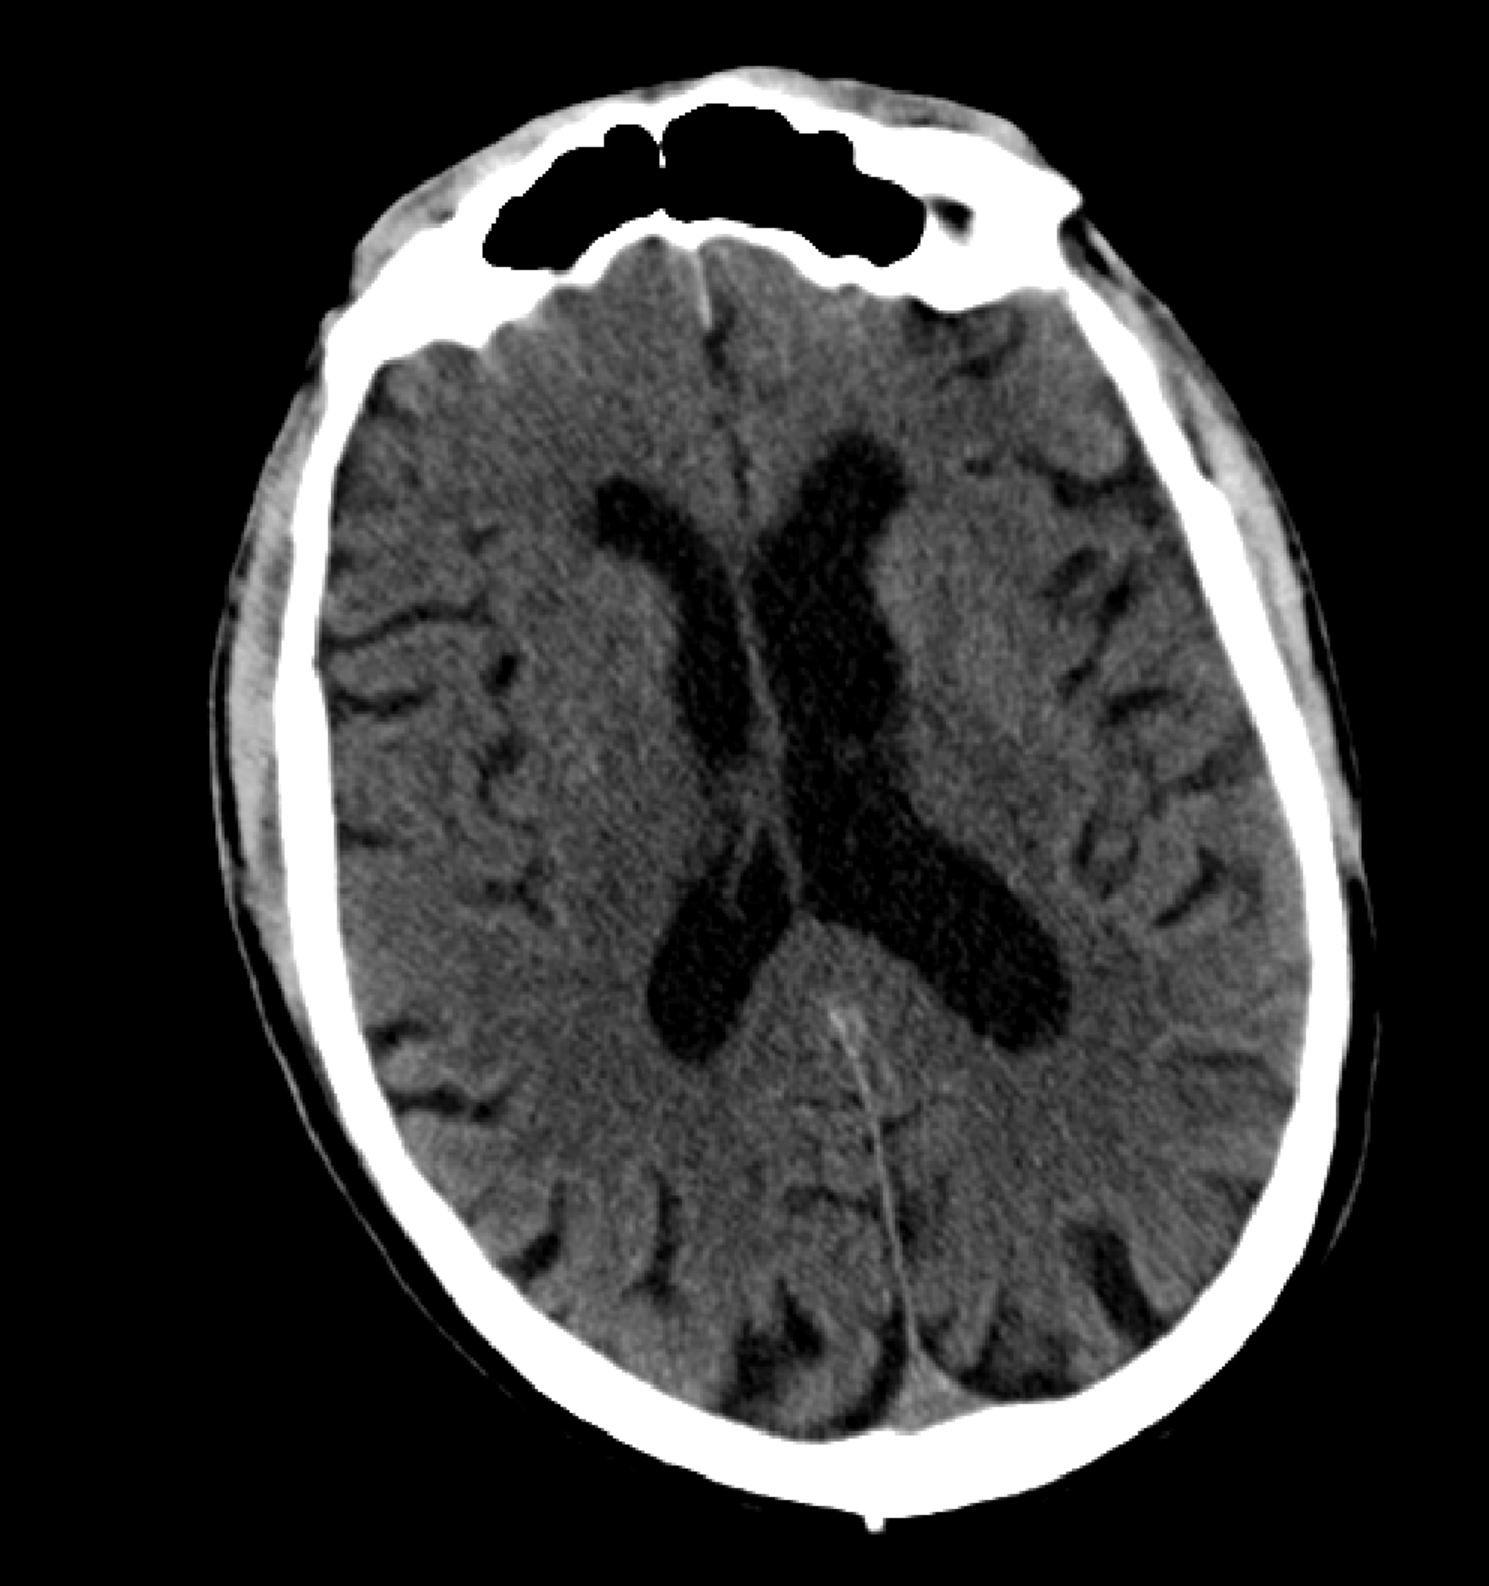

Now let's put it into our [CTobj class](https://github.com/DIDSR/pediatricIQphantoms/blob/main/src/pediatricIQphantoms/make_phantoms.py#L19) from [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms/tree/main) for more consistent functionality

In [17]:
from utils import CTobj

In [18]:
ctobj = CTobj(phantom[300], fov=250)

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 1 slices...
* Writing volume fraction files for 5 materials and 1 slices, plus the HU data...
* 

  0%|                                                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of      3 MB.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:00<00:00,  3.33it/s]


Prep view
Applying LSC...done.

Simulation is done.
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


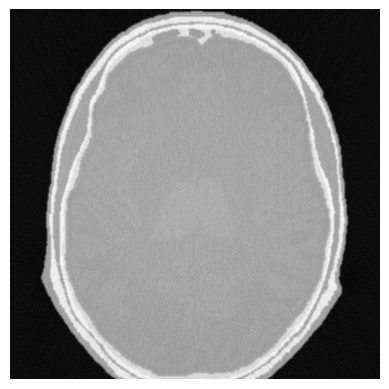

<class '__main__.CTobj'> default
Recon: (1, 512, 512) 25.0 cm FOV
Projections: (1000, 16, 900)

In [19]:
ctobj.run()

In [20]:
ctobj

<class '__main__.CTobj'> default
Recon: (1, 512, 512) 25.0 cm FOV
Projections: (1000, 16, 900)

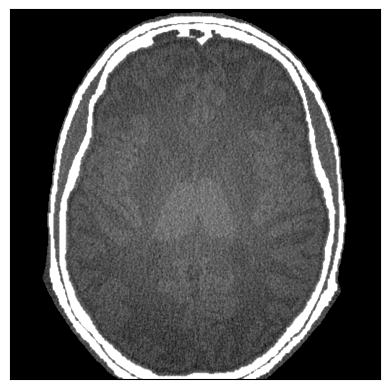

In [21]:
ctshow(ctobj.recon.squeeze())

In [22]:
import pydicom
from datetime import datetime

ctobj.write_to_dicom('test.dcm')

[PosixPath('test.dcm')]

## Now add a lesion

In [23]:
lut = material_lut[~material_lut['CT Number [HU]'].isna()]

In [24]:
lut['xcist material'].unique()

array(['CSF', 'white_matter', 'gray_matter', nan, 'ncat_skull'],
      dtype=object)

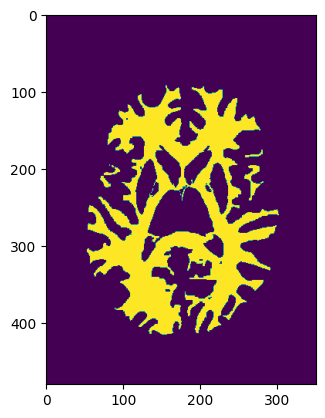

In [25]:
material = 'white_matter'
plt.imshow(phantom[300]==lut.loc[lut['xcist material']==material]['CT Number [HU]'].iloc[1])

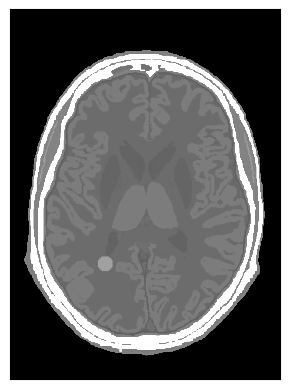

In [26]:
from dxcist.lesions import add_random_circle_lesion

radius = 10
contrast = 80
material = 'white_matter'

ground_truth_image = phantom[300]

brain_mask = ground_truth_image==lut.loc[lut['xcist material']==material]['CT Number [HU]'].iloc[1]
              
img_w_lesion, lesion_image, lesion_coords = add_random_circle_lesion(ground_truth_image, brain_mask, radius=radius, contrast=contrast)
ctshow(img_w_lesion)

In [ ]:
ctobj_lesion = CTobj(img_w_lesion, fov=250)
ctobj_lesion.run()

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 1 slices...
* Writing volume fraction files for 5 materials and 1 slices, plus the HU data...
* 

  0%|                                                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of      3 MB.


  2%|████▏                                                                                                                                                                                                                                   | 18/1000 [00:05<05:06,  3.21it/s]

In [ ]:
ctshow(ctobj_lesion.recon.squeeze())

In [ ]:
ctobj.write_to_dicom('test_lesion.dcm')

## TODOS

1. multislice e.g.

```python
ctobj = CTobj(phantom[290:310], fov=250)
```

2. fix water atten value such that CT numbers are correct (currently a small negative bias, eg brain rois around -20 HU when  they should be +20 HU)
3. Merge MIRT and CATSim as different subclasses of CTobj so its easy to switch between the two (the first step of making a ground truth phantom with attenuation coefficients is the same)
4. - I don't think MIRT is going to work with oct2py because the [wtfmex](https://web.eecs.umich.edu/~fessler/irt/irt/mex/oct/mi64/) compiled matlab/octave file gives en invalid ELF header, which indicates it needs to be recompiled and I dont have access to the source code
   - It looks like there is good progress at [Julia Image Recon](https://github.com/JuliaImageRecon), however CT examples are still missing.  I do not need another backend, XCIST is fine for now and is widely use.
5. demonstrate with segmented MRIs for more diversity and patient numbers

## Volume test
- this is limited realism since it is single slice, look into how to do multi-slice (todo 1)


In [ ]:
phantom.shape

In [ ]:
dx * 1000

Each slice is 0.5 mm natively, so to simulate 5 mm slices we will take every 10th, again this is an oversimplifcation since it doesn't account for volume averaging

In [ ]:
phantom[::10].shape

In [ ]:
slices = []
for phantom_slice in phantom[::10]:
    ctobj = CTobj(phantom_slice, fov=250)
    ctobj.run()
    slices.append(ctobj.recon)

In [ ]:
vol = np.stack(slices)